# AIR QUALITY ANOMALY DETECTION

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import joblib

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("viridis")


In [33]:
manual_preprocessed_italy_data = pd.read_excel('../Preprocessed Data/manual_preprocessed_italy_air_quality_data.xlsx')
manual_preprocessed_italy_data.head()

,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1080,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,1140,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,1200,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,1260,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1320,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [34]:
# 3. Exploratory Data Analysis
print("Performing exploratory data analysis...")

# Basic statistics
print("\nBasic Statistics:")
summary_stats = manual_preprocessed_italy_data.describe()
print(summary_stats)

# Missing values analysis
missing_values = manual_preprocessed_italy_data.isnull().sum()
missing_percentage = (missing_values / len(manual_preprocessed_italy_data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 
                             'Percentage': missing_percentage})
print("\nMissing Data Analysis:")
print(missing_data)

Performing exploratory data analysis...

Basic Statistics:
              Time       CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  \
count  9357.000000  9357.000000  9357.000000  9357.000000  9357.000000   
mean    689.871754   -34.207524  1048.869652  -159.090093     1.865576   
std     415.412009    77.657170   329.817015   139.789093    41.380154   
min       0.000000  -200.000000  -200.000000  -200.000000  -200.000000   
25%     300.000000     0.600000   921.000000  -200.000000     4.004958   
50%     660.000000     1.500000  1052.500000  -200.000000     7.886653   
75%    1080.000000     2.600000  1221.250000  -200.000000    13.636091   
max    1380.000000    11.900000  2039.750000  1189.000000    63.741476   

       PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  \
count    9357.000000  9357.000000   9357.000000  9357.000000   9357.000000   
mean      894.475963   168.604200    794.872333    58.135898   1391.363266   
std       342.315902   257.424561    321

In [35]:
# 4. Data Preprocessing
print("Preprocessing data for anomaly detection...")

# Handle missing values using forward fill then backward fill
df_filled = manual_preprocessed_italy_data.fillna(method='ffill').fillna(method='bfill')

# Select numerical columns for anomaly detection
# Exclude any remaining non-numeric columns
numeric_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()

# Normalize data
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_filled[numeric_cols]),
    columns=numeric_cols,
    index=df_filled.index
)

Preprocessing data for anomaly detection...


C:\Users\phamt\AppData\Local\Temp\ipykernel_22944\3042962070.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = manual_preprocessed_italy_data.fillna(method='ffill').fillna(method='bfill')


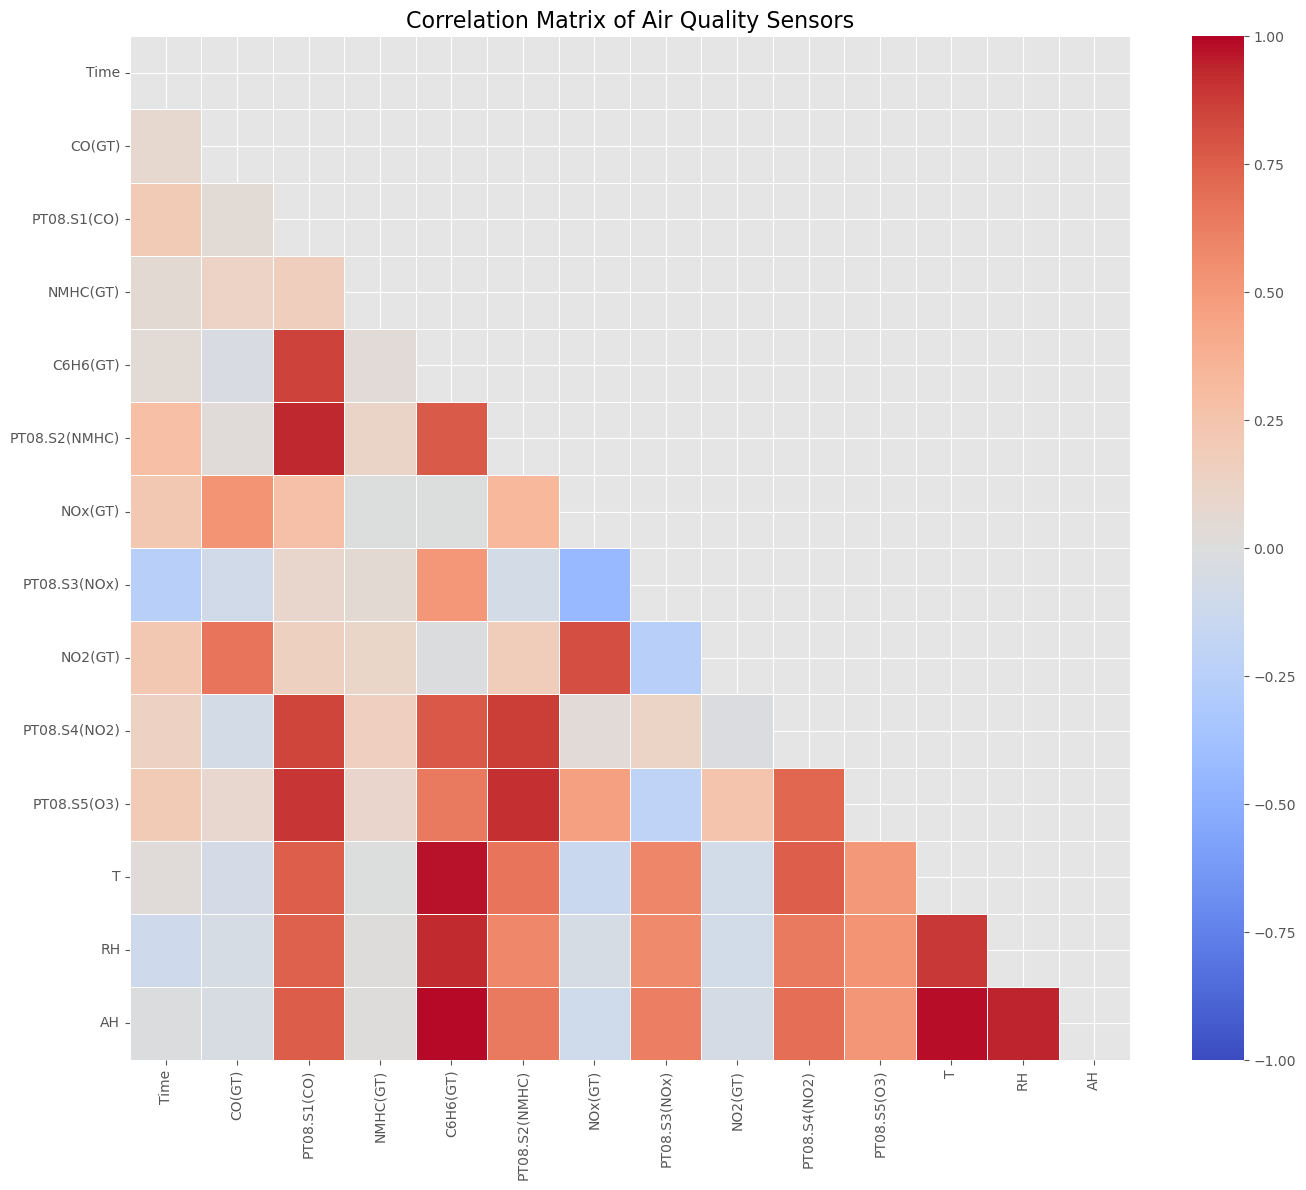

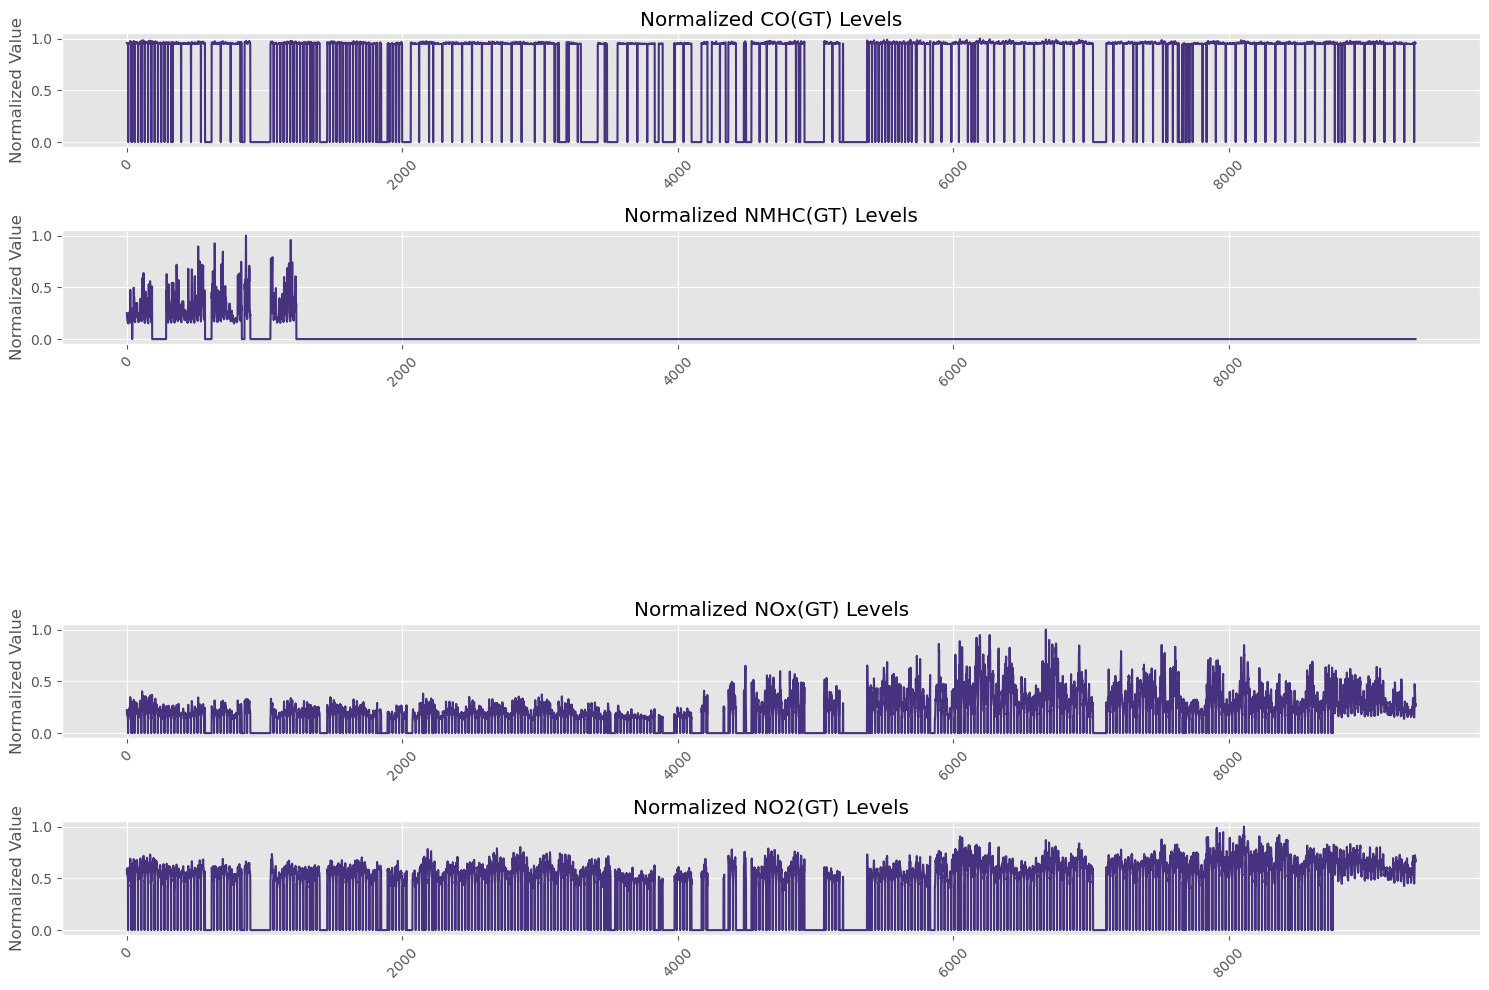

In [36]:
# Correlation heatmap
plt.figure(figsize=(14, 12))
correlation = df_normalized.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=False, cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Air Quality Sensors', fontsize=16)
plt.tight_layout()
plt.show()

# Time series plots for key pollutants
pollutants = ['CO(GT)', 'NMHC(GT)', 'Benzene(GT)', 'NOx(GT)', 'NO2(GT)']
plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants, 1):
    if pollutant in df_normalized.columns:
        plt.subplot(len(pollutants), 1, i)
        plt.plot(df_normalized.index, df_normalized[pollutant])
        plt.title(f'Normalized {pollutant} Levels')
        plt.ylabel('Normalized Value')
        plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Performing dimensionality reduction...


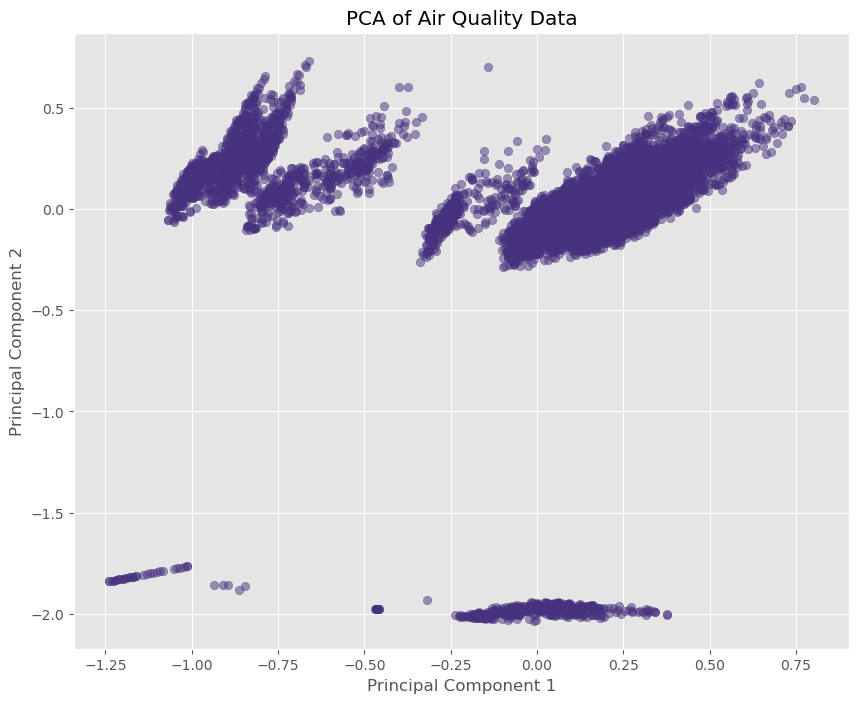

In [37]:
# 6. Dimensionality Reduction for Visualization
print("Performing dimensionality reduction...")

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normalized.values)
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=df_normalized.index)

plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5)
plt.title('PCA of Air Quality Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [38]:
# 7. Anomaly Detection with Isolation Forest
print("Detecting anomalies using Isolation Forest...")

# Apply Isolation Forest
contamination = 0.05  # Assuming 5% of data points are anomalies
iso_forest = IsolationForest(contamination=contamination, random_state=42)
df_normalized['anomaly'] = iso_forest.fit_predict(df_normalized)
df_normalized['anomaly'] = df_normalized['anomaly'].map({1: 0, -1: 1})  # 1 for anomaly, 0 for normal

# Count anomalies
anomaly_count = df_normalized['anomaly'].sum()
print(f"\nIsolation Forest detected {anomaly_count} anomalies ({anomaly_count/len(df_normalized)*100:.2f}%)")

Detecting anomalies using Isolation Forest...

Isolation Forest detected 468 anomalies (5.00%)


Visualizing detected anomalies...


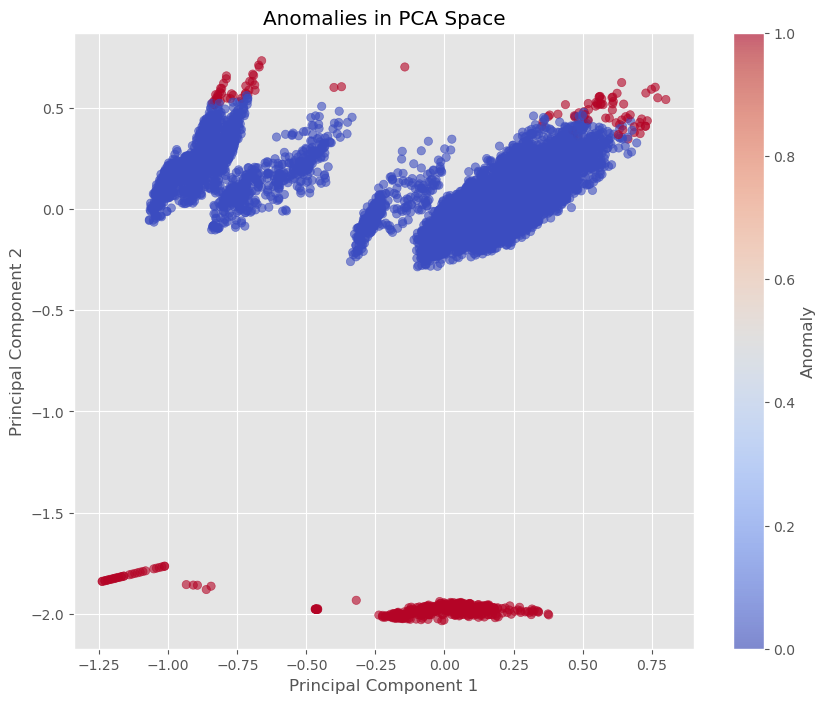

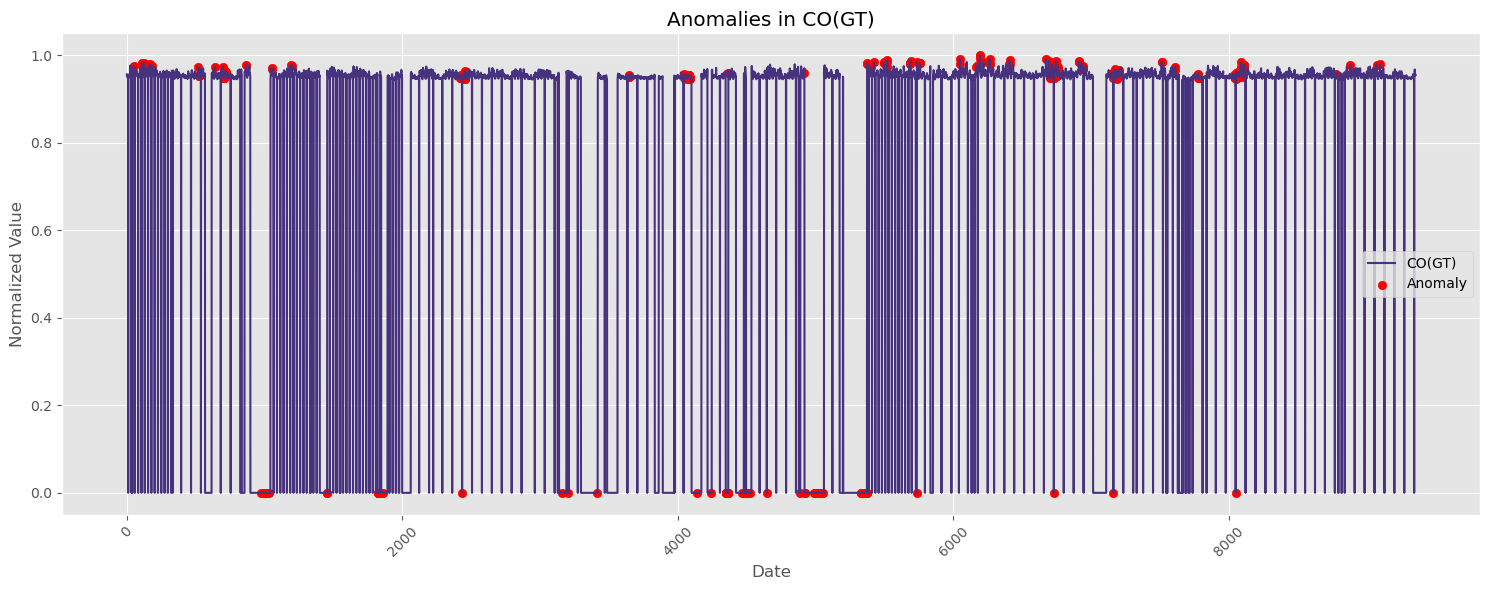

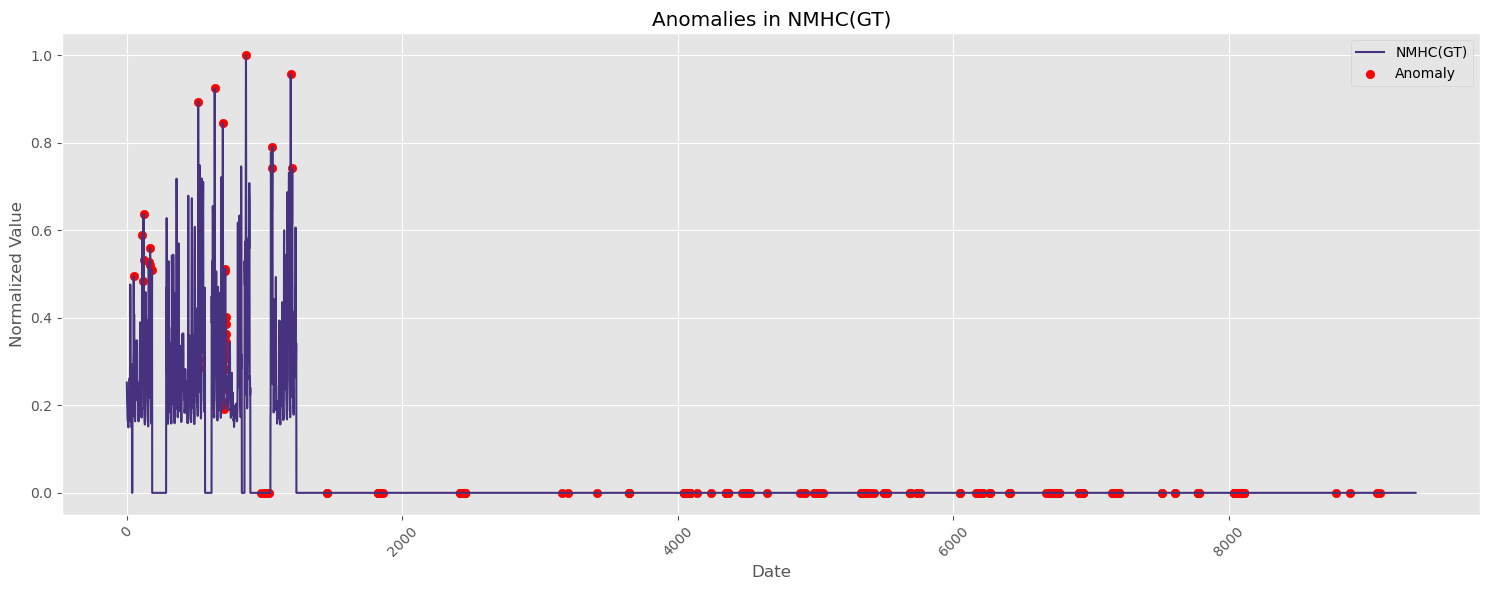

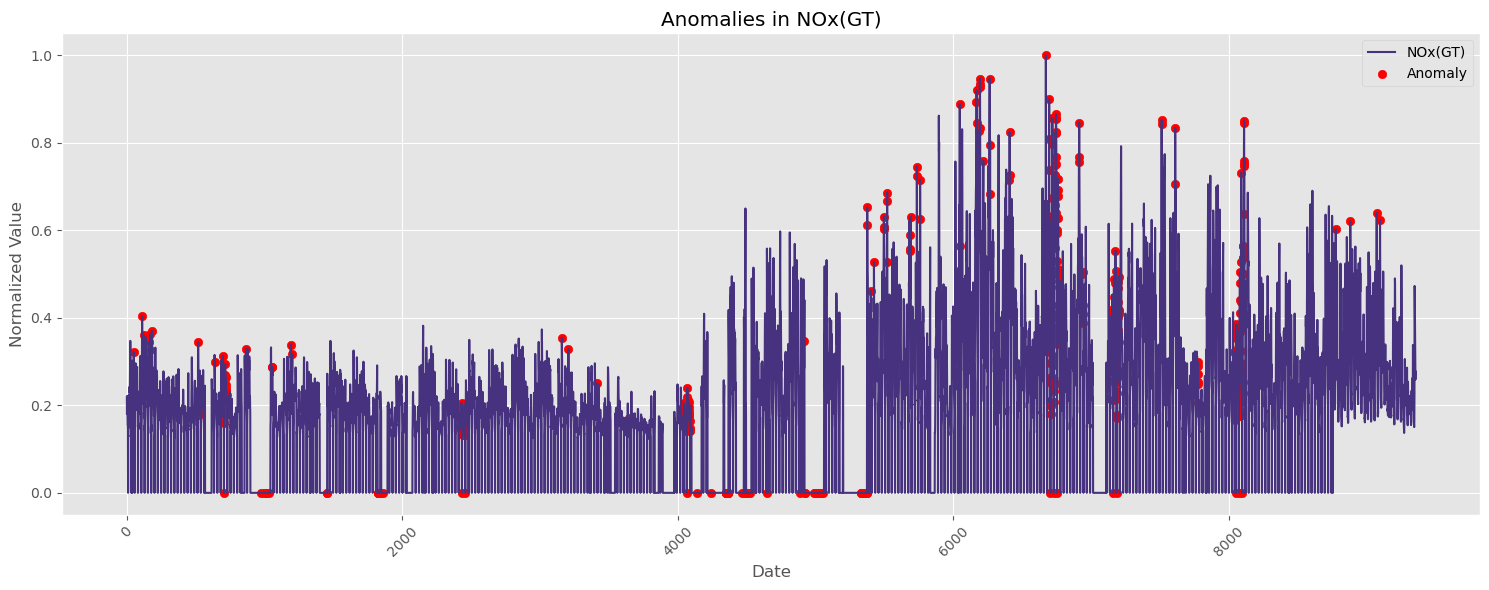

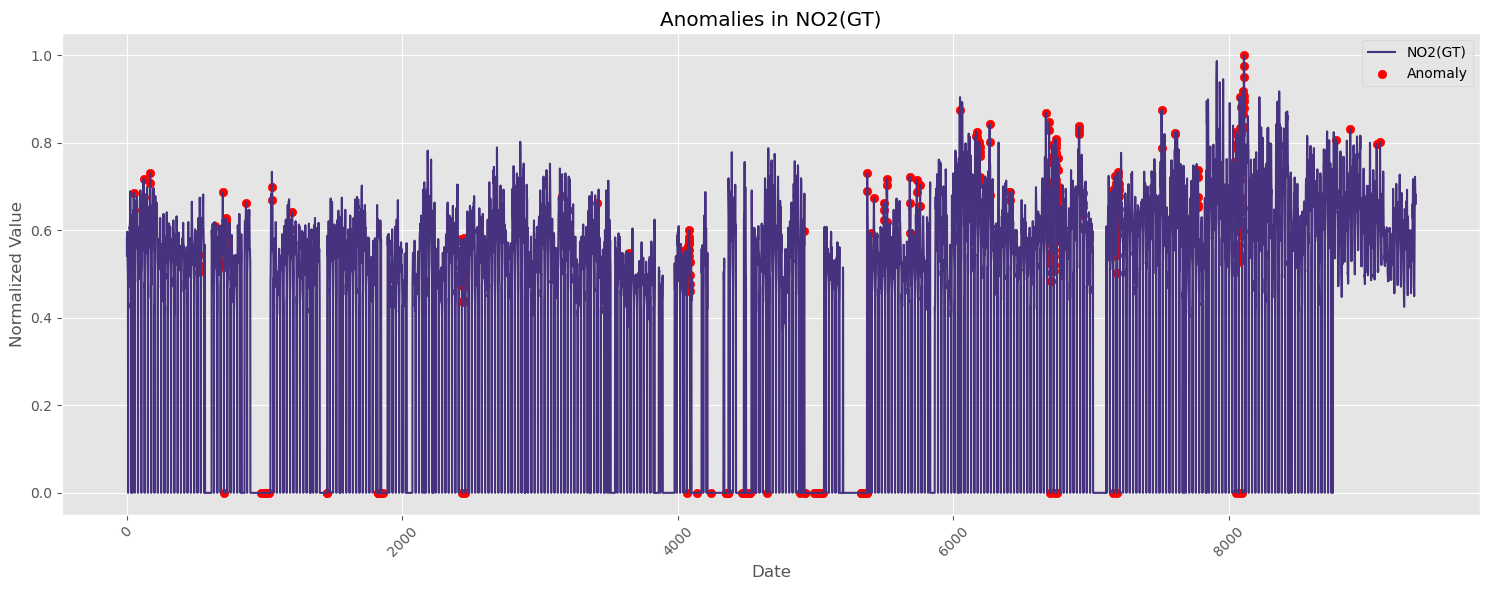

In [39]:
# 8. Visualize Anomalies
print("Visualizing detected anomalies...")

# Visualize anomalies in PCA space
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_normalized['anomaly'], cmap='coolwarm', alpha=0.6)
plt.title('Anomalies in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Anomaly')
plt.show()

# Visualize anomalies for each pollutant
for pollutant in pollutants:
    if pollutant in df_normalized.columns:
        plt.figure(figsize=(15, 6))
        plt.plot(df_normalized.index, df_normalized[pollutant], label=pollutant)
        anomaly_points = df_normalized[df_normalized['anomaly'] == 1]
        plt.scatter(anomaly_points.index, anomaly_points[pollutant], 
                   color='red', label='Anomaly')
        plt.title(f'Anomalies in {pollutant}')
        plt.xlabel('Date')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [40]:
# 9. Compare with DBSCAN (Secondary Algorithm)
print("Comparing with DBSCAN algorithm...")

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
df_normalized['dbscan_labels'] = dbscan.fit_predict(df_normalized.drop('anomaly', axis=1))
df_normalized['dbscan_anomaly'] = np.where(df_normalized['dbscan_labels'] == -1, 1, 0)

# Count DBSCAN anomalies
dbscan_anomaly_count = df_normalized['dbscan_anomaly'].sum()
print(f"DBSCAN detected {dbscan_anomaly_count} anomalies ({dbscan_anomaly_count/len(df_normalized)*100:.2f}%)")

# Agreement between methods
agreement = (df_normalized['anomaly'] == df_normalized['dbscan_anomaly']).sum() / len(df_normalized) * 100
print(f"Agreement between Isolation Forest and DBSCAN: {agreement:.2f}%")

Comparing with DBSCAN algorithm...
DBSCAN detected 12 anomalies (0.13%)
Agreement between Isolation Forest and DBSCAN: 95.02%


Analyzing feature importance for anomalies...


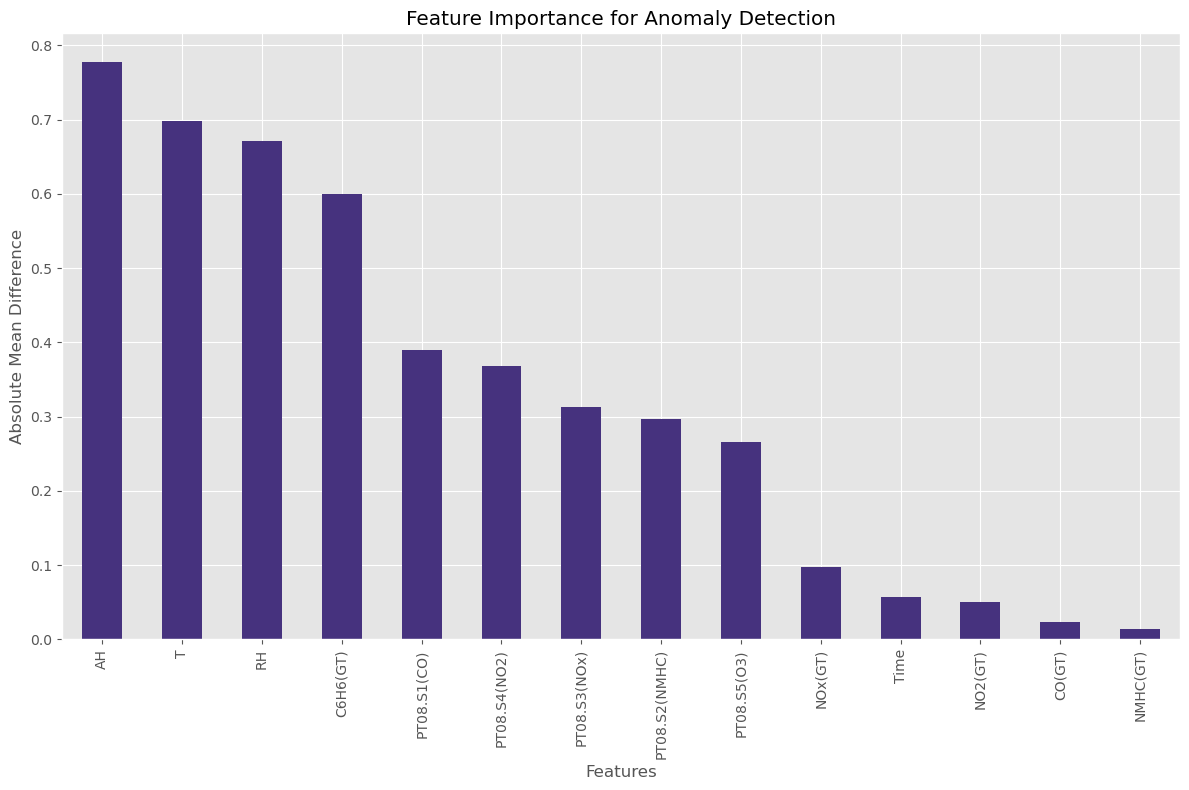

In [41]:
# 10. Feature Importance Analysis
print("Analyzing feature importance for anomalies...")

# Analyze which features contribute most to anomalies
anomalous_data = df_normalized[df_normalized['anomaly'] == 1].drop(['anomaly', 'dbscan_labels', 'dbscan_anomaly'], axis=1)
normal_data = df_normalized[df_normalized['anomaly'] == 0].drop(['anomaly', 'dbscan_labels', 'dbscan_anomaly'], axis=1)

# Calculate mean values for each feature in both groups
anomalous_means = anomalous_data.mean()
normal_means = normal_data.mean()

# Calculate absolute difference
feature_importance = abs(anomalous_means - normal_means)
feature_importance = feature_importance.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance.plot(kind='bar')
plt.title('Feature Importance for Anomaly Detection')
plt.xlabel('Features')
plt.ylabel('Absolute Mean Difference')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Classifying anomalies...

Anomaly Classification:
anomaly_type
Pollution Event    380
Sensor Fault        88
Name: count, dtype: int64


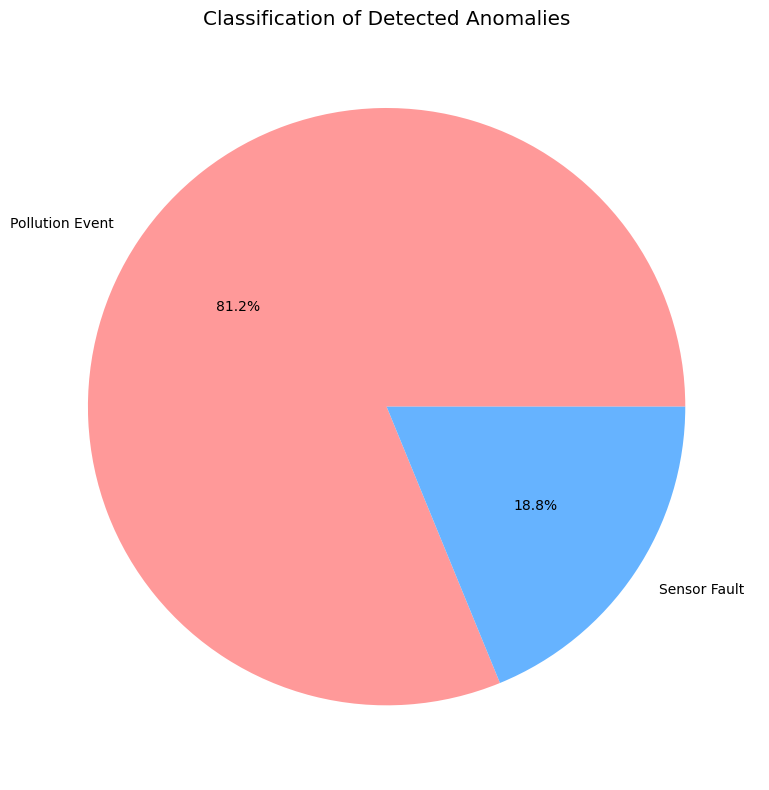

In [42]:
# 12. Anomaly Classification
print("Classifying anomalies...")

# Calculate z-scores for each feature in anomalous points
anomalous_indices = df_normalized[df_normalized['anomaly'] == 1].index
z_scores = pd.DataFrame(index=anomalous_indices)

for col in numeric_cols:
    mean_val = df_normalized[col].mean()
    std_val = df_normalized[col].std()
    z_scores[col] = (df_normalized.loc[anomalous_indices, col] - mean_val) / std_val

# If multiple sensors show extreme values at the same time, likely a pollution event
# If only one sensor shows extreme value, likely a sensor fault
z_score_threshold = 3
extreme_features = (abs(z_scores) > z_score_threshold).sum(axis=1)
df_normalized.loc[anomalous_indices, 'anomaly_type'] = np.where(
    extreme_features > 1, 
    'Pollution Event', 
    'Sensor Fault'
)

# Count each type
anomaly_types = df_normalized[df_normalized['anomaly'] == 1]['anomaly_type'].value_counts()
print("\nAnomaly Classification:")
print(anomaly_types)

# Visualize the classification
plt.figure(figsize=(10, 8))
plt.pie(anomaly_types, labels=anomaly_types.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Classification of Detected Anomalies')
plt.tight_layout()
plt.show()

In [43]:
# 13. Save Trained Models
print("Saving trained models and components...")

# Create directory if it doesn't exist
save_dir = '../Saved Models'

# Save Isolation Forest model
iso_forest_path = f'{save_dir}/air_quality_isolation_forest.pkl'
joblib.dump(iso_forest, iso_forest_path)
print(f"Isolation Forest model saved to: {iso_forest_path}")

# Save DBSCAN model
dbscan_path = f'{save_dir}/air_quality_dbscan.pkl'
joblib.dump(dbscan, dbscan_path)
print(f"DBSCAN model saved to: {dbscan_path}")

# Save scaler for preprocessing new data
scaler_path = f'{save_dir}/air_quality_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"MinMaxScaler saved to: {scaler_path}")

# Save PCA model for visualization
pca_path = f'{save_dir}/air_quality_pca.pkl'
joblib.dump(pca, pca_path)
print(f"PCA model saved to: {pca_path}")



Saving trained models and components...
Isolation Forest model saved to: ../Saved Models/air_quality_isolation_forest.pkl
DBSCAN model saved to: ../Saved Models/air_quality_dbscan.pkl
MinMaxScaler saved to: ../Saved Models/air_quality_scaler.pkl
PCA model saved to: ../Saved Models/air_quality_pca.pkl
